In [14]:
import pickle
import torch.utils.data as Data
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.metrics import r2_score
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
from pylab import mpl
import pandas as pd
from sklearn.model_selection import train_test_split
from pylab import mpl
import matplotlib
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, max_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor


In [26]:
mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'

data = np.array(pd.read_excel("C:/Users/chj/Desktop/chj.xlsx",header=None))

EPOCH =200# train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE =4
time_up = 1    # rnn time step / image height
INPUT_SIZE = 6       # rnn input size / image width
LR2 = 0.005


#GRU数据处理
x = data[:,1:5]
y = data[1:,0:1]




In [27]:
y

array([[ 160.],
       [ 176.],
       [ 346.],
       ...,
       [1329.],
       [1358.],
       [1364.]])

In [28]:
x = (preprocessing.minmax_scale(x))
# print(x.shape,y.shape)
N_IDEAS = x.shape[1]
# print(N_IDEAS)

# 数据绑定，将time_up条数据进行绑定
midd1 = np.zeros((x.shape[0]-1,time_up,x.shape[1]))
for i in range(1,x.shape[0]):
    # if i >= time_up:
    midd1[i-1, :, :] = x[i - time_up+1:i+1, :]
feature1 = midd1
feature_gru = feature1
y_gru = y
# print("midd1.shape",midd1.shape)

train_x=feature_gru
train_y=y_gru

train_x = torch.from_numpy(train_x)  # shape (batch, time_step, input_size)
train_y = torch.from_numpy(train_y)
train_x=train_x.float()
train_y=train_y.float()
# train_datax=train_x[:(-65),]
# train_datay=train_y[:(-65),]
train_datax=train_x[:,]
train_datay=train_y[:,]
# verfication_datax=train_x[(-1000):(-200),]
# verfication_datay=train_y[(-1000):(-200),]
verfication_datax=train_x[(-1000):,]
verfication_datay=train_y[(-1000):,]


torch_data=Data.TensorDataset(train_datax,train_datay)
train_loader = Data.DataLoader(dataset=torch_data, batch_size=BATCH_SIZE, shuffle=True)
# train_loader = Data.DataLoader(dataset=torch_data, batch_size=BATCH_SIZE)


class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.GRU(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=64,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
            # dropout=0.3,
            bidirectional = True,
        )
        self.out =nn.Linear(128, 1)
        self.m = nn.ReLU()
        # self.dropout = nn.Dropout(0.5)
        # self.out1 = nn.Linear(2, 1)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size), h_c
        r_out, (h_n) = self.rnn(x, None)   # None represents zero initial hidden state
        # print("r_out",r_out)
        # print("x",r_out)
        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        # out = self.dropout(out)
        out = self.m(out)
        # out = self.out1(out)
        return out

rnn = RNN()
print(rnn)


optimizer = torch.optim.Adam(rnn.parameters(), lr=LR2,weight_decay=1e-5)   # optimize all cnn parameters
loss_func = nn.MSELoss()                     # the target label is not one-hotted

loss_train=[]
loss_verfication=[]
R2_train=[]
R2_verfication=[]
RMSE_train=[]
RMSE_verfication=[]

for epoch in range(EPOCH):
     print("EPOCH", epoch)
     for step, (b_x, b_y) in enumerate(train_loader): # gives batch data
        b_x= b_x.view(-1, 1, 6) # reshape x to (batch, time_step, input_size)
        # print('EPOCH',epoch,'STEP', step, 'X',b_x,'Y', b_y)
        output = rnn(b_x)
        a = output.shape                            # rnn output
        # print(a)
        # print(output)
        # print(output.shape)
        # print(b_y.shape)
        loss = loss_func(output, b_y)    # cross entropy loss
        # print(loss)
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

     if epoch % 1 == 0:
         rnn.eval()
         output = rnn(train_datax)  # cnn output
         loss = loss_func(output,train_datay)
         loss = torch.sqrt(loss)
         output = output.detach().numpy()
         b_y = train_datay.detach().numpy()


         c = tf.sqrt(mean_squared_error(output, b_y)) #############################
         c = c.numpy()
         d = mean_squared_error(output, b_y)
         b = mean_absolute_error(output, b_y)
         a = r2_score(output, b_y)

         loss = loss.detach().numpy()
         loss_train.append(loss)
         R2_train.append(a)
         RMSE_train.append(c)
         # print(output, b_y)
         print('train', epoch)
         print('R2:', a)
         print('MAE:', b)
         print('MSE:', d)
         print('RMSE:', c)
         print('loss:', loss)

     if epoch % 1 == 0:
         rnn.eval()
         output = rnn(verfication_datax)  # cnn output
         loss = loss_func(output, verfication_datay)
         loss = torch.sqrt(loss)
         output = output.detach().numpy()
         b_y = verfication_datay.detach().numpy()

         c = tf.sqrt(mean_squared_error(output, b_y))   #######################################
         c = c.numpy()
         d = mean_squared_error(output, b_y)
         b = mean_absolute_error(output, b_y)
         a = r2_score(output, b_y)

         loss = loss.detach().numpy()
         loss_verfication.append(loss)
         R2_verfication.append(a)
         RMSE_verfication.append(c)
         #
         # result = np.array([a, b, c, d])[:, np.newaxis]
         # result = result.reshape(1, 4)
         # result = pd.DataFrame(result)
         # result = np.around(result, 4)
         # col_name = ["R2", "MAE", "RMSE", "MSE"]
         # result.to_excel('gru_para_6.xlsx', index=False, header=col_name)
         #




RNN(
  (rnn): GRU(6, 64, batch_first=True, bidirectional=True)
  (out): Linear(in_features=128, out_features=1, bias=True)
  (m): ReLU()
)
EPOCH 0


RuntimeError: shape '[-1, 1, 6]' is invalid for input of size 16

In [29]:
import shap
shap.initjs()  # notebook环境下，加载用于可视化的JS代码

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [20]:
explainer = shap.TreeExplainer(train_loader, train_x )
shap_values = explainer.shap_values(X)  # 传入特征矩阵X，计算SHAP值

InvalidMaskerError: Unsupported masker type: <class 'torch.Tensor'>!

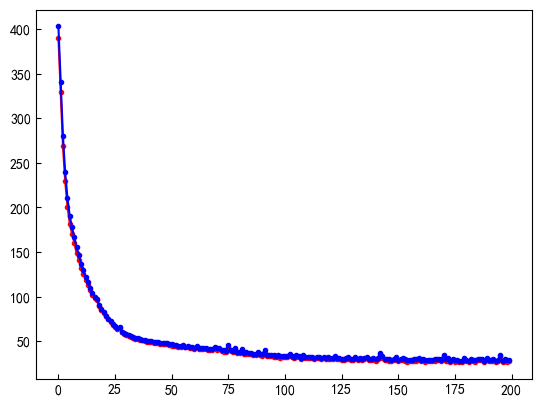

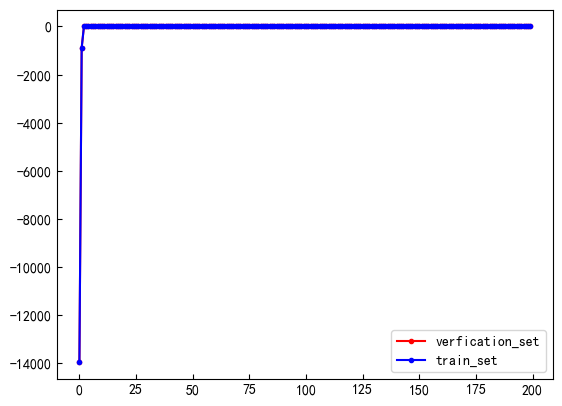

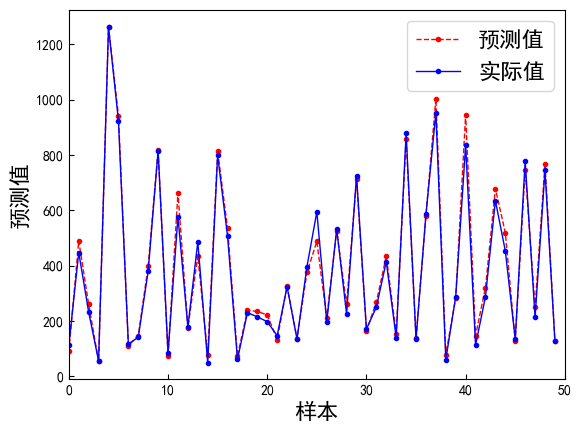

In [15]:
 
# 画epoch-loss图
loss_verfication = np.array(loss_verfication)
loss_train = np.array(loss_train)
plt.plot(loss_verfication, c='r',marker='.')
plt.plot(loss_train, c='b',marker='.')
plt.savefig('gru_epoch-loss.png')
plt.show()

# 画R2图
R2_verfication = np.array(R2_verfication)
R2_train = np.array(R2_verfication)
line1, = plt.plot(R2_verfication, c='r',marker='.')
line2, = plt.plot(R2_train, c='b',marker='.')
plt.legend((line1,line2),['verfication_set','train_set'])
plt.savefig('gru_epoch-R2_1层.png')
plt.show()

R2_verfication = R2_verfication.reshape(-1,1)
R2_train = R2_train.reshape(-1,1)
R2 = np.hstack((R2_verfication,R2_train))
R2 = pd.DataFrame(R2)
col_name = ["R2_verfication", "R2_train"]
R2.to_excel('gru_R2_1层.xlsx', index=False, header=col_name)

##############
plt.xlim(0,50)
index = np.random.choice(output.shape[0],50, replace=False)
# shape[0]指返回prediction_value的总数，np.random.choice指从prediction_value中随机选出200个，False指不能重复
pred_value = output[index]
real_value = b_y[index]
plt.plot(pred_value, label='预测值', linewidth=1.0, color='red', linestyle='--', marker='.')
plt.plot(real_value, label='实际值', linewidth=1.0, color='blue', marker='.')
plt.legend(fontsize=16)
plt.xlabel("样本", size=16)
plt.ylabel("预测值", size=16)
plt.show()

In [16]:
print (pred_value)
print (real_value)

[[  90.21811 ]
 [ 489.74625 ]
 [ 259.9119  ]
 [  54.014637]
 [1263.6749  ]
 [ 942.2309  ]
 [ 110.795425]
 [ 146.66797 ]
 [ 399.23294 ]
 [ 819.10114 ]
 [  73.362045]
 [ 663.82275 ]
 [ 175.29161 ]
 [ 436.0629  ]
 [  77.16197 ]
 [ 814.00024 ]
 [ 534.88385 ]
 [  72.20106 ]
 [ 238.7957  ]
 [ 234.36145 ]
 [ 221.87155 ]
 [ 132.3142  ]
 [ 326.2477  ]
 [ 136.15814 ]
 [ 375.23734 ]
 [ 487.7539  ]
 [ 210.29187 ]
 [ 526.3969  ]
 [ 259.60223 ]
 [ 712.5262  ]
 [ 164.60382 ]
 [ 268.05106 ]
 [ 434.30508 ]
 [ 153.86476 ]
 [ 858.89044 ]
 [ 137.8609  ]
 [ 581.16064 ]
 [1003.6099  ]
 [  78.20822 ]
 [ 283.30682 ]
 [ 945.1679  ]
 [ 146.8683  ]
 [ 320.68912 ]
 [ 678.231   ]
 [ 518.91797 ]
 [ 128.82306 ]
 [ 746.82166 ]
 [ 248.89406 ]
 [ 768.16583 ]
 [ 126.82683 ]]
[[ 112.6  ]
 [ 447.4  ]
 [ 232.   ]
 [  55.81 ]
 [1262.   ]
 [ 924.   ]
 [ 116.9  ]
 [ 141.1  ]
 [ 381.   ]
 [ 815.   ]
 [  84.83 ]
 [ 577.   ]
 [ 178.   ]
 [ 485.6  ]
 [  49.4  ]
 [ 798.   ]
 [ 506.4  ]
 [  60.8  ]
 [ 230.   ]
 [ 215.   ]
 [ 197.35

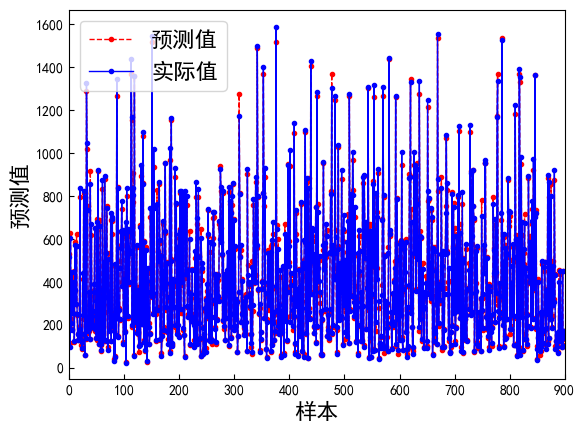

[[ 414.69226 ]
 [ 530.9844  ]
 [ 116.0031  ]
 [ 627.0051  ]
 [ 227.06377 ]
 [ 178.61922 ]
 [ 438.06427 ]
 [ 342.876   ]
 [ 254.62495 ]
 [ 450.27127 ]
 [ 118.98823 ]
 [ 586.2719  ]
 [ 359.83148 ]
 [ 295.474   ]
 [ 623.2191  ]
 [ 244.89372 ]
 [ 156.23863 ]
 [ 129.1316  ]
 [ 134.67007 ]
 [ 168.11705 ]
 [ 792.6725  ]
 [ 195.748   ]
 [ 106.015945]
 [ 139.41765 ]
 [  86.046036]
 [ 414.69226 ]
 [ 226.18423 ]
 [ 814.1045  ]
 [ 137.73886 ]
 [  61.370346]
 [ 812.6659  ]
 [ 134.05869 ]
 [1286.899   ]
 [1018.4411  ]
 [ 753.2543  ]
 [ 163.39195 ]
 [ 293.48566 ]
 [ 172.6768  ]
 [ 132.4706  ]
 [ 914.85815 ]
 [ 186.25734 ]
 [ 616.6063  ]
 [ 227.06377 ]
 [ 251.80074 ]
 [ 220.4802  ]
 [ 359.91843 ]
 [ 334.97534 ]
 [ 651.0369  ]
 [ 169.35858 ]
 [ 318.57166 ]
 [ 139.95848 ]
 [ 692.7849  ]
 [ 131.01318 ]
 [ 914.11487 ]
 [ 154.6698  ]
 [ 111.38192 ]
 [ 370.67676 ]
 [ 688.2177  ]
 [ 107.10585 ]
 [  77.96459 ]
 [ 260.33112 ]
 [ 829.511   ]
 [ 127.432915]
 [ 475.10687 ]
 [ 125.07085 ]
 [ 876.7765  ]
 [ 123.012

In [10]:
plt.xlim(0,900)
index = np.random.choice(output.shape[0],900, replace=False)
# shape[0]指返回prediction_value的总数，np.random.choice指从prediction_value中随机选出200个，False指不能重复
pred_value = output[index]
real_value = b_y[index]
plt.plot(pred_value, label='预测值', linewidth=1.0, color='red', linestyle='--', marker='.')
plt.plot(real_value, label='实际值', linewidth=1.0, color='blue', marker='.')
plt.legend(fontsize=16)
plt.xlabel("样本", size=16)
plt.ylabel("预测值", size=16)
plt.show()
print (pred_value)
print (real_value)

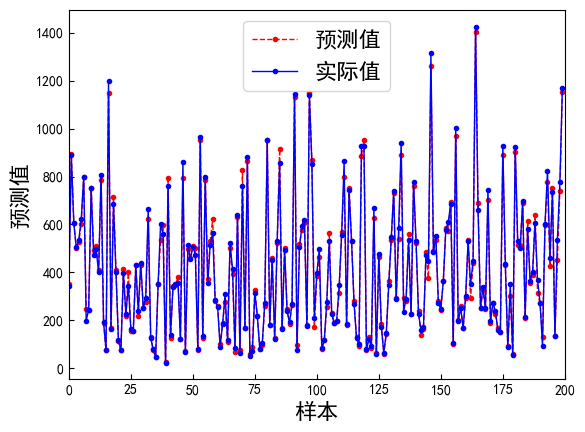

[[ 350.4926  ]
 [ 894.062   ]
 [ 605.977   ]
 [ 500.3894  ]
 [ 525.0458  ]
 [ 603.8463  ]
 [ 796.0836  ]
 [ 249.47104 ]
 [ 243.37943 ]
 [ 751.76434 ]
 [ 495.33484 ]
 [ 509.94574 ]
 [ 408.58386 ]
 [ 786.9059  ]
 [ 189.8979  ]
 [  74.47678 ]
 [1149.9219  ]
 [ 168.11705 ]
 [ 713.37524 ]
 [ 409.0654  ]
 [ 112.30214 ]
 [  74.69299 ]
 [ 413.75946 ]
 [ 217.56435 ]
 [ 399.9821  ]
 [ 155.73662 ]
 [ 157.1131  ]
 [ 432.9267  ]
 [ 219.16728 ]
 [ 432.36728 ]
 [ 252.99075 ]
 [ 277.76578 ]
 [ 624.02203 ]
 [ 131.11374 ]
 [  76.54956 ]
 [  48.804943]
 [ 351.982   ]
 [ 535.2976  ]
 [ 596.7731  ]
 [  25.093452]
 [ 795.45325 ]
 [ 128.22327 ]
 [ 342.9508  ]
 [ 347.41983 ]
 [ 379.33078 ]
 [ 124.00106 ]
 [ 794.8712  ]
 [  73.09695 ]
 [ 498.75995 ]
 [ 460.23438 ]
 [ 511.97528 ]
 [ 499.9809  ]
 [  77.154144]
 [ 952.62085 ]
 [ 127.6531  ]
 [ 787.0322  ]
 [ 373.09863 ]
 [ 530.9844  ]
 [ 623.2191  ]
 [ 282.66583 ]
 [ 258.6093  ]
 [ 101.75352 ]
 [ 189.8979  ]
 [ 277.02545 ]
 [ 109.60048 ]
 [ 502.50513 ]
 [ 394.631

In [11]:
plt.xlim(0,200)
index = np.random.choice(output.shape[0],200, replace=False)
# shape[0]指返回prediction_value的总数，np.random.choice指从prediction_value中随机选出200个，False指不能重复
pred_value = output[index]
real_value = b_y[index]
plt.plot(pred_value, label='预测值', linewidth=1.0, color='red', linestyle='--', marker='.')
plt.plot(real_value, label='实际值', linewidth=1.0, color='blue', marker='.')
plt.legend(fontsize=16)
plt.xlabel("样本", size=16)
plt.ylabel("预测值", size=16)
plt.show()
print (pred_value)
print (real_value)

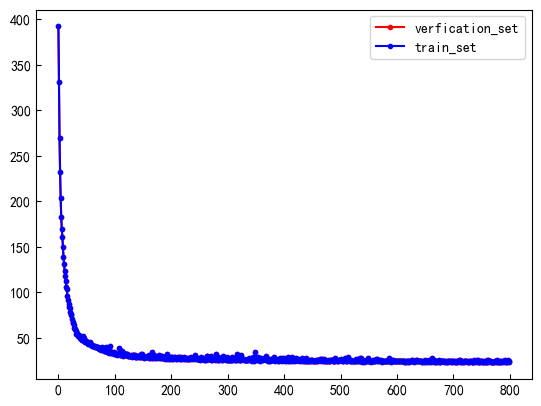

In [12]:
RMSE_verfication = np.array(RMSE_verfication)
RMSE_train = np.array(RMSE_verfication)
line1, = plt.plot(RMSE_verfication, c='r',marker='.')
line2, = plt.plot(RMSE_train, c='b',marker='.')
plt.legend((line1,line2),['verfication_set','train_set'])
plt.savefig('gru_epoch-RMSE_6.png')
plt.show()

In [5]:
RMSE_verfication = RMSE_verfication.reshape(-1,1)
RMSE_train = RMSE_train.reshape(-1,1)
RMSE = np.hstack((RMSE_verfication,RMSE_train))
RMSE = pd.DataFrame(RMSE)
col_name = ["RMSE_verfication", "RMSE_train"]
RMSE.to_excel('gru_RMSE_6.xlsx', index=False, header=col_name)

In [6]:
# 画轨迹图
rnn.eval()
torch.save(obj=rnn.state_dict(), f="gru.pth")
print('para saved')

para saved


In [7]:
test_output = rnn(test_datax)
pred_y = test_output.view(-1).data.numpy()
pred_y = pred_y.reshape(-1,2)
x_pre = pred_y[-65:,0]
y_pre = pred_y[-65:,1]
x_real = test_datay[-65:,0]
y_real = test_datay[-65:,1]

X = data[-65:,0] - 1.40
Y = data[-65:,1] - 1.58
line1, = plt.plot(X,Y, c='g',marker='.')
line2, = plt.plot(x_pre,y_pre, c='r',marker='.')
line3, = plt.plot(x_lable,y_lable, c='b',marker='.')
plt.legend((line1,line2,line3),['path_set','pre_set',"lable_set"])
plt.savefig('gru_test6.png')
plt.show()


NameError: name 'test_datax' is not defined

In [ ]:
result = np.array([X,Y,x_pre,y_pre,x_lable,y_lable])[:, np.newaxis]
result = result.reshape(-1, 6)
result = pd.DataFrame(result)
col_name = ["X","Y","x_pre","y_pre","x_lable","y_lable"]
result.to_excel('plot_result.xlsx', index=False, header=col_name)

In [7]:
a = [158,160,176,346,291,347]

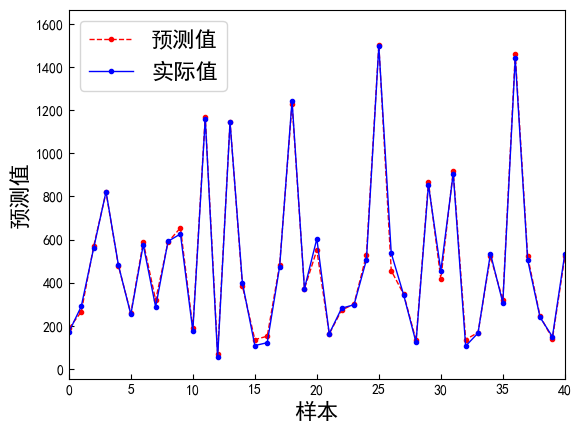

[[ 188.251   ]
 [ 264.5801  ]
 [ 568.0519  ]
 [ 819.46295 ]
 [ 478.13614 ]
 [ 257.63788 ]
 [ 589.0032  ]
 [ 319.2075  ]
 [ 588.7452  ]
 [ 654.3122  ]
 [ 189.32693 ]
 [1170.065   ]
 [  70.63102 ]
 [1147.1779  ]
 [ 384.16718 ]
 [ 136.25072 ]
 [ 152.37497 ]
 [ 482.56342 ]
 [1230.0442  ]
 [ 372.32745 ]
 [ 551.2209  ]
 [ 162.98312 ]
 [ 273.03653 ]
 [ 301.3985  ]
 [ 529.11383 ]
 [1502.7253  ]
 [ 456.10382 ]
 [ 347.25726 ]
 [ 133.00693 ]
 [ 867.0586  ]
 [ 417.57886 ]
 [ 918.82355 ]
 [ 136.72327 ]
 [ 169.316   ]
 [ 521.99994 ]
 [ 319.88956 ]
 [1460.0151  ]
 [ 522.01526 ]
 [ 245.10445 ]
 [ 140.74019 ]
 [ 521.99994 ]
 [ 119.42416 ]
 [ 168.4141  ]
 [ 362.7809  ]
 [ 263.0275  ]
 [ 235.67508 ]
 [ 748.14655 ]
 [ 259.87897 ]
 [ 189.32693 ]
 [ 823.93695 ]
 [ 308.01758 ]
 [ 899.4366  ]
 [ 258.49277 ]
 [ 180.15602 ]
 [ 623.1901  ]
 [ 429.0277  ]
 [ 244.18033 ]
 [ 658.22797 ]
 [ 314.49188 ]
 [ 881.4368  ]
 [ 594.84296 ]
 [ 901.1453  ]
 [  74.72202 ]
 [ 634.2464  ]
 [ 540.6707  ]
 [1348.4932  ]
 [ 121.030

In [29]:
plt.xlim(0,40)
index = [560,
785,
241,
38,
212,
321,
66,
829,
449,
899,
305,
-10,
704,
989,
655,
410,
496,
440,
-6,
576,
609,
670,
282,
635,
595,
955,
803,
848,
725,
977,
155,
-19,
406,
257,
163,
789,
950,
224,
468,
366,
163,
399,
498,
546,
279,
274,
451,
474,
305,
39,
177,
105,
347,
687,
71,
520,
628,
898,
481,
104,
202,
48,
750,
915,
8,
997,
391,
571,
738,
692,
69,
362,
55,
909,
303,
949,
430,
483,
995,
746,
551,
40,
773,
448,
286,
649,
913,
275,
379,
476,
918,
922,
496,
403,
230,
524,
508,
721,
398,
572,
866,
786,
215,
294,
341,
-35,
619,
162,
469,
933,
159,
143,
85,
613,
911,
761,
429,
611,
739,
455,
261,
674,
694,
395,
494,
691,
984,
956,
917,
781,
705,
394,
774,
214,
617,
821,
216,
28,
825,
672,
568,
722,
576,
577,
165,
822,
458,
23,
645,
565,
907,
979,
587,
736,
397,
780,
446,
857,
711,
231,
335,
553,
-29,
184,
819,
64,
360,
630,
791,
583,
534,
545,
696,
604,
501,
17,
-3,
402,
-7,
487,
756,
747,
233,
806,
244,
492,
942,
644,
878,
709,
686,
837,
490,
315,
271,
731,
387,
962,
153,
60,
566,
796,
108,
152,
616,
778,
589,
314,
784,
658,
879,
107,
767,
727,
324,
511,
627,
853,
527,
428,
715,
685,
349,
369,
325,
-21,
167,
960,
-32,
550,
641,
676,
720,
218,
650,
113,
188,
112,
242,
330,
452,
868,
585,
708,
958,
532,
203,
509,
888,
76,
607,
0,
128,
752,
902,
965,
121,
3,
319,
937,
371,
582,
258,
199,
416,
283,
598,
57,
762,
779,
376,
25,
42,
12,
677,
144,
414,
874,
-28,
838,
345,
127,
555,
221,
-31,
229,
930,
1,
954,
723,
766,
234,
103,
820,
157,
329,
425,
815,
593,
578,
372,
13,
95,
459,
273,
944,
516,
-24,
548,
135,
656,
327,
594,
420,
861,
971,
2,
782,
567,
119,
211,
873,
173,
269,
744,
972,
266,
130,
882,
493,
343,
-27,
68,
31,
106,
714,
447,
225,
534,
415,
307,
973,
948,
934,
171,
-17,
592,
217,
672,
795,
248,
751,
34,
156,
141,
435,
881,
79,
-36,
39,
11,
358,
226,
903,
862,
735,
622,
27,
799,
15,
323,
633,
87,
999,
444,
835,
963,
485,
265,
81,
-25,
120,
648,
90,
9,
198,
530,
204,
665,
206,
674,
970,
845,
661,
528,
906,
783,
313,
365,
-20,
936,
149,
612,
301,
169,
380,
981,
308,
276,
205,
442,
126,
150,
908,
96,
264,
]
# shape[0]指返回prediction_value的总数，np.random.choice指从prediction_value中随机选出200个，False指不能重复
pred_value = output[index]
real_value = b_y[index]
plt.plot(pred_value, label='预测值', linewidth=1.0, color='red', linestyle='--', marker='.')
plt.plot(real_value, label='实际值', linewidth=1.0, color='blue', marker='.')
plt.legend(fontsize=16)
plt.xlabel("样本", size=16)
plt.ylabel("预测值", size=16)
plt.show()
print (pred_value)
print (real_value)

In [15]:
data1 = np.array(pd.read_csv("C:/Users/chj/Desktop/99.csv"))


In [8]:
print(data)

[]


In [19]:
conda config

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.

Note: you may need to restart the kernel to use updated packages.



PackagesNotFoundError: The following packages are not available from current channels:

  - config

Current channels:

  - https://conda.anaconda.org/anaconda/win-64
  - https://conda.anaconda.org/anaconda/noarch
  - https://repo.anaconda.com/pkgs/main/win-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/win-64
  - https://repo.anaconda.com/pkgs/r/noarch
  - https://repo.anaconda.com/pkgs/msys2/win-64
  - https://repo.anaconda.com/pkgs/msys2/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.


